In [1]:
from allensdk.api.queries.glif_api import GlifApi
from allensdk.core.cell_types_cache import CellTypesCache
import allensdk.core.json_utilities as json_utilities

In [2]:
#neuronal_model_id = 566302806
#neuronal_model_id = 566290459  # http://celltypes.brain-map.org/experiment/electrophysiology/386049446
neuronal_model_id = 637925685  # https://celltypes.brain-map.org/experiment/electrophysiology/623893177


# download model metadata
glif_api = GlifApi()
nm = glif_api.get_neuronal_models_by_id([neuronal_model_id])[0]

In [3]:
nm

{'id': 637925685,
 'name': '3 LIF + Afterspike Currents (LIF-ASC)_Sim1-Cre_KJ18;Ai14-345650.03.01.01',
 'neuron_reconstruction_id': None,
 'neuronal_model_template_id': 395310475,
 'specimen_id': 623893177,
 'well_known_files': [{'attachable_id': 637925685,
   'attachable_type': 'NeuronalModel',
   'download_link': '/api/v2/well_known_file_download/637942491',
   'id': 637942491,
   'path': '/external/mousecelltypes/prod1185/neuronal_model_637925685/637925685_neuron_config.json',
   'well_known_file_type_id': 329230374,
   'well_known_file_type': {'id': 329230374,
    'name': 'NeuronalModelParameters'}}]}

In [4]:
# download the model configuration file
nc = glif_api.get_neuron_configs([neuronal_model_id])[neuronal_model_id]
neuron_config = glif_api.get_neuron_configs([neuronal_model_id])[neuronal_model_id]
#json_utilities.write('neuron_config.json', neuron_config)

In [5]:
#import allensdk.core.json_utilities as json_utilities
#from allensdk.model.glif.glif_neuron import GlifNeuron

# initialize the neuron
#neuron_config = json_utilities.read('neuron_config.json')[neuronal_model_id]
#neuron = GlifNeuron.from_dict(neuron_config)

# make a short square pulse. stimulus units should be in Amps.
#stimulus = [ 0.0 ] * 100 + [ 10e-9 ] * 100 + [ 0.0 ] * 100

# important! set the neuron's dt value for your stimulus in seconds
#neuron.dt = 5e-6

# simulate the neuron
#output = neuron.run(stimulus)

#voltage = output['voltage']
#threshold = output['threshold']
#spike_times = output['interpolated_spike_times']

In [6]:
neuron_config

{'El_reference': -0.077016232808431,
 'C': 2.330231073607339e-10,
 'asc_amp_array': [-5.67567950400874e-11, -6.05973770880532e-10],
 'init_threshold': 0.02770505017308362,
 'threshold_reset_method': {'params': {}, 'name': 'inf'},
 'th_inf': 0.02770505017308362,
 'spike_cut_length': 185,
 'init_AScurrents': [0.0, 0.0],
 'init_voltage': 0.0,
 'threshold_dynamics_method': {'params': {}, 'name': 'inf'},
 'voltage_reset_method': {'params': {}, 'name': 'zero'},
 'extrapolation_method_name': 'endpoints',
 'dt': 5e-05,
 'voltage_dynamics_method': {'params': {}, 'name': 'linear_forward_euler'},
 'El': 0.0,
 'asc_tau_array': [0.1, 0.01],
 'R_input': 123376678.38880895,
 'AScurrent_dynamics_method': {'params': {}, 'name': 'exp'},
 'AScurrent_reset_method': {'params': {'r': [1.0, 1.0]}, 'name': 'sum'},
 'dt_multiplier': 10,
 'th_adapt': None,
 'coeffs': {'a': 1,
  'C': 1,
  'b': 1,
  'G': 1,
  'th_inf': 1.038436943935436,
  'asc_amp_array': [1.0, 1.0]},
 'type': 'GLIF'}

In [7]:
from brian2.units import *

In [8]:
neuronpars = {
    #'E_leak': neuron_config['El_reference'] * volt,
    'E_leak': neuron_config['El'] * volt,
    'C': neuron_config['C'] * farad,
    'Rin': neuron_config['R_input'] * ohm,
    'g_leak': 1/(neuron_config['R_input'] * ohm),
    'Vcut': neuron_config['th_inf'] * volt,
    'asc_amplitudes': neuron_config['asc_amp_array'] * amp,
    'asc_tau_array': neuron_config['asc_tau_array'] * second,
    'asc_init_values': neuron_config['init_AScurrents'] * amp
}

In [9]:
N_asc = len(neuronpars['asc_amplitudes'])
for i in range(N_asc):
    neuronpars['k'+str(i)] = (1/neuron_config['asc_tau_array'][i]) * Hz
    neuronpars['tau_asc'+str(i)] = neuron_config['asc_tau_array'][i] * second
    neuronpars['A_asc'+str(i)] = neuron_config['asc_amp_array'][i] * amp

In [10]:
neuronpars

{'E_leak': 0. * volt,
 'C': 233.02310736 * pfarad,
 'Rin': 123.37667839 * Mohm,
 'g_leak': 8.10525954 * nsiemens,
 'Vcut': 27.70505017 * mvolt,
 'asc_amplitudes': array([ -56.75679504, -605.97377088]) * pamp,
 'asc_tau_array': array([100.,  10.]) * msecond,
 'asc_init_values': array([0., 0.]) * amp,
 'k0': 10. * hertz,
 'tau_asc0': 100. * msecond,
 'A_asc0': -56.75679504 * pamp,
 'k1': 100. * hertz,
 'tau_asc1': 10. * msecond,
 'A_asc1': -0.60597377 * namp}

In [11]:
import brian2 as b2

In [12]:
eqs = '''
dvm/dt = (g_leak*(E_leak - vm) + I_ext + I_asc) / C : volt
I_ext : amp
'''

#threshold_cond = 'vm > ' + repr(neuronpars['E_leak'] + neuronpars['Vcut'])
threshold_cond = 'vm > ' + repr(neuronpars['Vcut'])


In [13]:
N_asc = len(neuronpars['asc_amplitudes'])
I_asc_string = ''
reset_cond = 'vm = ' + repr(neuronpars['E_leak']) + '; '

if N_asc > 0:
    for i in range(N_asc):
        I_asc_i = 'I_asc' + str(i)
        I_asc_string += I_asc_i
        reset_cond += I_asc_i + ' = ' + I_asc_i + '+' + 'A_asc'+str(i)
        if i < N_asc-1:
            I_asc_string += ' + '
            reset_cond += '; '
else:
    I_asc_string = '0*amp'

I_asc_string

'I_asc0 + I_asc1'

In [14]:
reset_cond

'vm = 0. * volt; I_asc0 = I_asc0+A_asc0; I_asc1 = I_asc1+A_asc1'

In [15]:
threshold_cond

'vm > 27.70505017 * mvolt'

In [16]:
asc_eq = 'dI_asc/dt = -I_asc/tau_asc : amp'
final_eqs = b2.Equations(eqs, I_asc=I_asc_string)
for i in range(N_asc):
    final_eqs += b2.Equations(asc_eq, I_asc = 'I_asc'+str(i), tau_asc='tau_asc'+str(i))
final_eqs

dvm/dt = (I_asc0 + I_asc1 + I_ext + g_leak*(E_leak - vm))/C : volt
I_ext : amp
dI_asc0/dt = -I_asc0/tau_asc0 : amp
dI_asc1/dt = -I_asc1/tau_asc1 : amp


In [17]:
print(str(final_eqs))

dvm/dt = (g_leak*(E_leak - vm) + I_ext + I_asc0 + I_asc1) / C : volt
dI_asc0/dt = -I_asc0/tau_asc0 : amp
dI_asc1/dt = -I_asc1/tau_asc1 : amp
I_ext : amp


In [18]:
G = b2.NeuronGroup(1, final_eqs, threshold=threshold_cond, reset=reset_cond, namespace=neuronpars, method='euler')

In [20]:
G.vm = neuronpars['E_leak']
G.I_asc0 = 0*amp
G.I_asc1 = 0*amp

In [21]:
spikemon = b2.SpikeMonitor(G)
statemon = b2.StateMonitor(G, ('vm', 'I_asc0', 'I_asc1'), record=True)

In [22]:
net = b2.Network(G, spikemon, statemon)

In [23]:
net.run(100*ms)

In [24]:
from brian2tools import brian_plot

In [25]:
b2.defaultclock.dt = 0.01*ms
G.I_ext = 220*pA
net.run(1000*ms)
G.I_ext = 0*pA
net.run(100*ms)

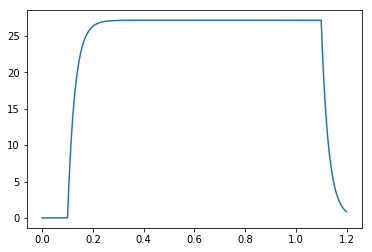

In [26]:
import matplotlib.pyplot as plt
plt.plot(statemon.t/second, statemon.vm[0]/mV)

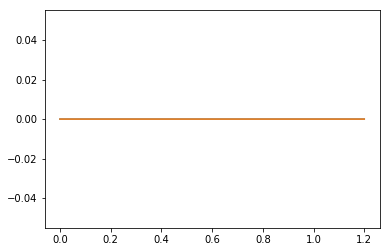

In [27]:
plt.plot(statemon.t/second, statemon.I_asc0[0]/pA, label='I_asc0')
plt.plot(statemon.t/second, statemon.I_asc1[0]/pA, label='I_asc1')

In [28]:
dict1 = {'a': 1, 'b':2}
dict2 = {'a': 100}
dict1.update(dict2)
dict1

{'a': 100, 'b': 2}